Idee:
Da aus der 9 Versuch kein brauchbares Resultat hervorkam, versucht man hier mögliche weisse Stellen weiss zu machen und den Rest schwarz stehen zu lassen.

Ausgangssituation:
Einige weisse Bilder können so entdeckt werden. Dies wäre unsere Lösung im geplannten Konzept gewesen, falls man weisse Signale erkennen wollten. Jedoch müsste man damit die Kamera mit 2 verschieden Konfigurationen haben um auch schwarze Signale mit der bewährten Methode zu finden.

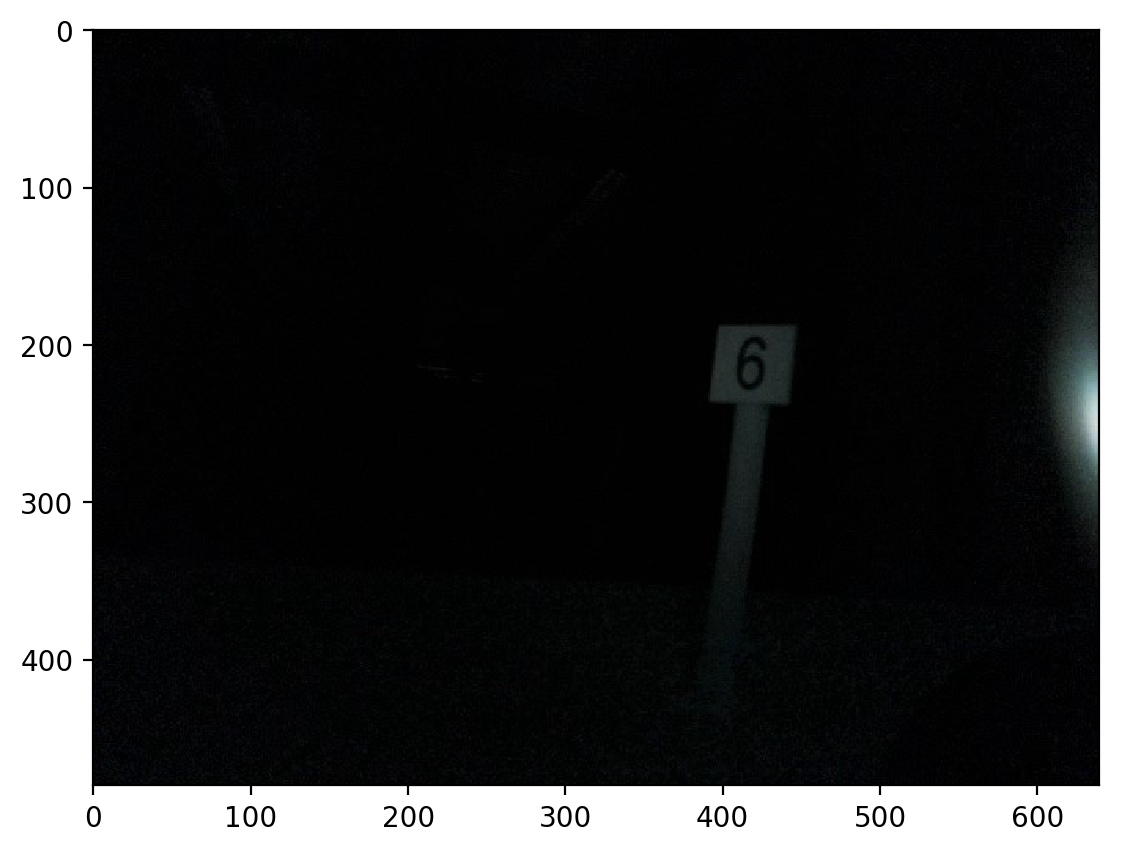

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
%matplotlib inline
# resolution of images in figure
mpl.rcParams['figure.dpi']= 200
# figure size in inches
mpl.rcParams["figure.figsize"] = [10,5]

image = cv2.imread('images/shutter9_iso800/white/white_6_10.jpg')
img = image.copy()
plt.imshow(image)

white_1_1
white_2_13
white_6_9
white_6_10
white_6_11
white_6_12
white_6_13
white_8_14
white_8_15
white_9_5
white_9_6
Methode 2:

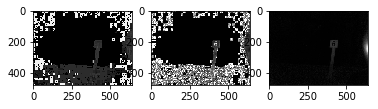

In [2]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hsv_h,hsv_s,hsv_v = cv2.split(hsv)
plt.subplot(1, 3, 1)
plt.imshow(hsv_h, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(hsv_s, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(hsv_v, cmap='gray')

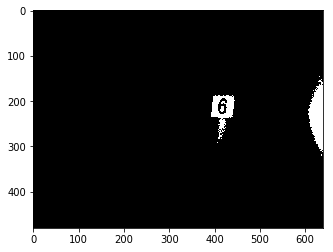

In [3]:
hsv_mask = hsv_v.copy()

threshold_map = hsv_v <= 35

hsv_mask[threshold_map] = 0
hsv_mask[hsv_v > 35] = 255

plt.imshow(hsv_mask, cmap='gray')

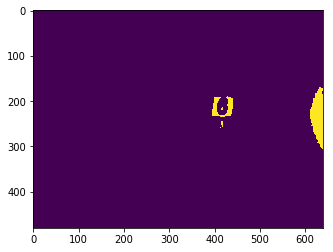

In [4]:
struct = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
image_erode = cv2.erode(hsv_mask, struct)
plt.imshow(image_erode)

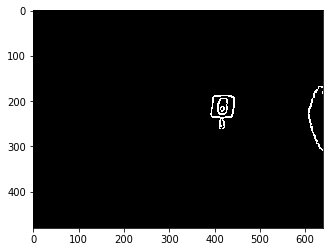

In [5]:
GAUSSIAN_SMOOTH_FILTER_SIZE = (3, 3)
ADAPTIVE_THRESH_BLOCK_SIZE = 11
ADAPTIVE_THRESH_WEIGHT = 9

height, width = image_erode.shape

imgBlurred = np.zeros((height, width, 1), np.uint8)

imgBlurred = cv2.GaussianBlur(image_erode, GAUSSIAN_SMOOTH_FILTER_SIZE, 0)
imgThresh = cv2.adaptiveThreshold(imgBlurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_WEIGHT)

plt.imshow(imgThresh, cmap='gray')

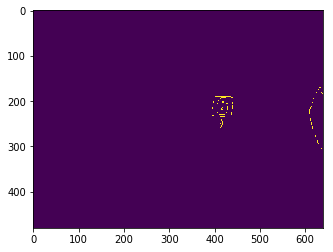

In [6]:
# Find edges in the image using canny edge detection method
# Calculate lower threshold and upper threshold using sigma = 0.33
v = np.median(hsv_mask)
low = 40
high = 150

edged = cv2.Canny(image_erode, low, high)

plt.imshow(edged)

416 248 rectangle 413 240 7 18
416 248 rectangle 413 240 7 18
419 202 square 418 201 3 3
419 202 square 418 201 3 3
418 211 rectangle 394 190 48 45
This is your signal
418 211 rectangle 394 190 48 45
This is your signal
623 220 rectangle 610 169 30 138


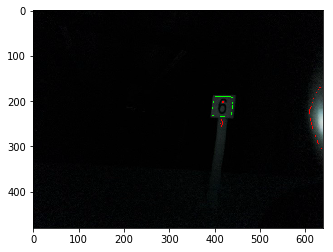

In [7]:
# After finding edges we have to find contours
# Contour is a curve of points with no gaps in the curve
# It will help us to find location of shapes

# cv2.RETR_EXTERNAL is passed to find the outermost contours (because we want to outline the shapes)
# cv2.CHAIN_APPROX_SIMPLE is removing redundant points along a line
(_, cnts, _) = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


'''
We are going to use contour approximation method to find vertices of
geometric shapes. The alogrithm  is also known as Ramer Douglas Peucker alogrithm.
In OpenCV it is implemented in cv2.approxPolyDP method.abs
detectShape() function below takes a contour as parameter and
then returns its shape
 '''


def detectShape(cnt):
    shape = 'unknown'
    # calculate perimeter using
    peri = cv2.arcLength(c, True)
    # apply contour approximation and store the result in vertices
    vertices = cv2.approxPolyDP(c, 0.04 * peri, True)

    # If the shape it triangle, it will have 3 vertices
    if len(vertices) == 3:
        shape = 'triangle'

    # if the shape has 4 vertices, it is either a square or
    # a rectangle
    elif len(vertices) == 4:
        # using the boundingRect method calculate the width and height
        # of enclosing rectange and then calculte aspect ratio

        x, y, width, height = cv2.boundingRect(vertices)
        aspectRatio = float(width) / height

        # a square will have an aspect ratio that is approximately
        # equal to one, otherwise, the shape is a rectangle
        if aspectRatio >= 0.95 and aspectRatio <= 1.05:
            shape = "square"
        else:
            shape = "rectangle"

    # if the shape is a pentagon, it will have 5 vertices
    elif len(vertices) == 5:
        shape = "pentagon"

    # otherwise, we assume the shape is a circle
    else:
        shape = "circle"

    # return the name of the shape
    return shape


# Now we will loop over every contour
# call detectShape() for it and
# write the name of shape in the center of image

# loop over the contours
for c in cnts:
    # compute the moment of contour
    M = cv2.moments(c)
    if(M['m00']!=0.0):
        # From moment we can calculte area, centroid etc
        # The center or centroid can be calculated as follows
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])

        # call detectShape for contour c
        shape = detectShape(c)
        
        if((shape == "square" or shape == "rectangle")) :
            
            x,y,w,h = cv2.boundingRect(c)
            
            
            ratio = w/h

            # Outline the contours
            if(ratio > 0.75 and ratio < 1.25 and w > 10 and h > 10):
                cv2.drawContours(img, [c], -1, (0, 255, 0), 1)
                print(cX, cY, shape, x,y,w,h)
                print('This is your signal')
            else:
                cv2.drawContours(img, [c], -1, (255, 0, 0), 1)
                print(cX, cY, shape, x,y,w,h)

            # Write the name of shape on the center of shapes
            #cv2.putText(img, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # show the output image
            plt.imshow(img)